# Test Implemtation of DFA

Reference used for the theory - https://www.frontiersin.org/articles/10.3389/fphys.2012.00450/full

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import DFA

In [2]:
PI = np.pi

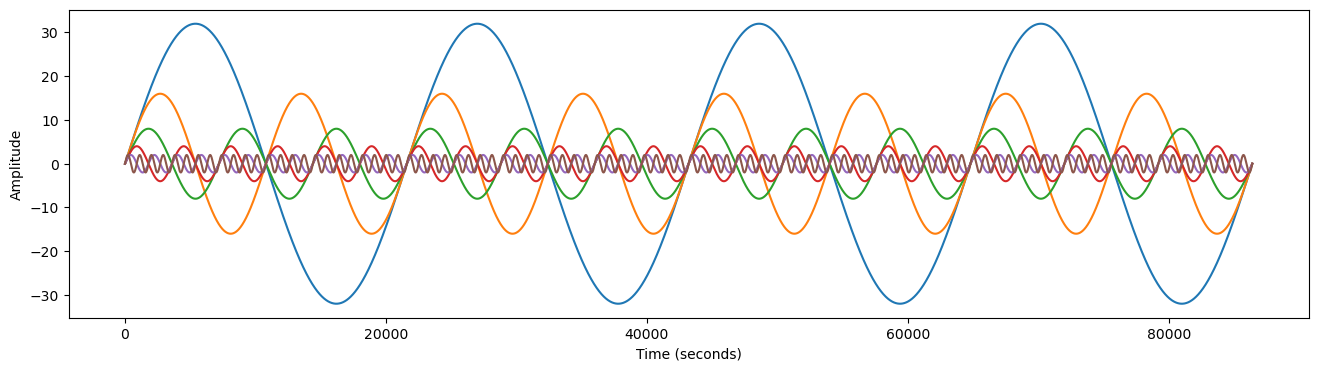

In [3]:
# Create a set of test signals. We make sure that signals with a lower frequency have higher amplitude.
T = 24 * 60 * 60  # A 24 hour period for all the signals.
Fs = 0.01 # Sampling frequency
t = np.arange(0, T, Fs)
# Holds the time periods of the oscillation signals. Inputs in hours.
TT = np.array([6, 3, 2, 1, 0.5, 0.25])
TT = TT * 60 * 60
F = 1 / np.array(TT)  # Frequency of the singals.
A = np.array([32, 16, 8, 4, 2, 2])

# Let us plot each of the singals.
f = plt.figure(figsize=(16, 4))
Ys = None
for i in range(0, len(TT)):
    Y = A[i] * np.sin(2 * PI * t * F[i])
    if Ys is None:
        Ys = np.zeros(Y.size)
    Ys = Ys + Y
    plt.plot(t, Y)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid()

The above is a pure beauty. Just looking at it is calming. Seeing the high frequency signals with low frequency signals. Love it.

Let us see how the sum of all these signals look :)

In [4]:
def plotSignal(t, X, title=''):
    f = plt.figure(figsize=(16, 4))
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.plot(t, X)    
    plt.grid()

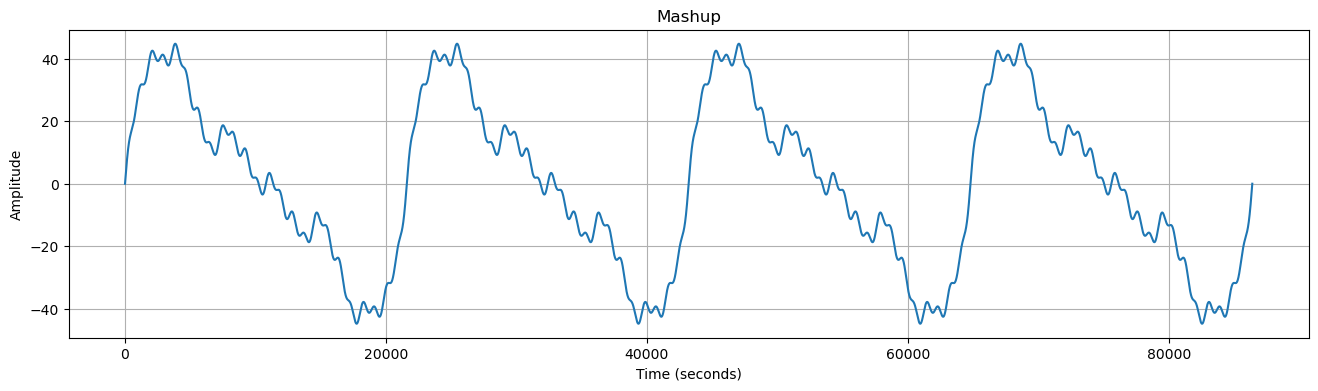

In [5]:
plotSignal(t, Ys, 'Mashup')

The top one is also beautiful. We can see the longer duration signals still maintain their cool factor.

# Time to Start Coding DFA

In [6]:
Xcum = DFA.calSignalProfile(Ys)

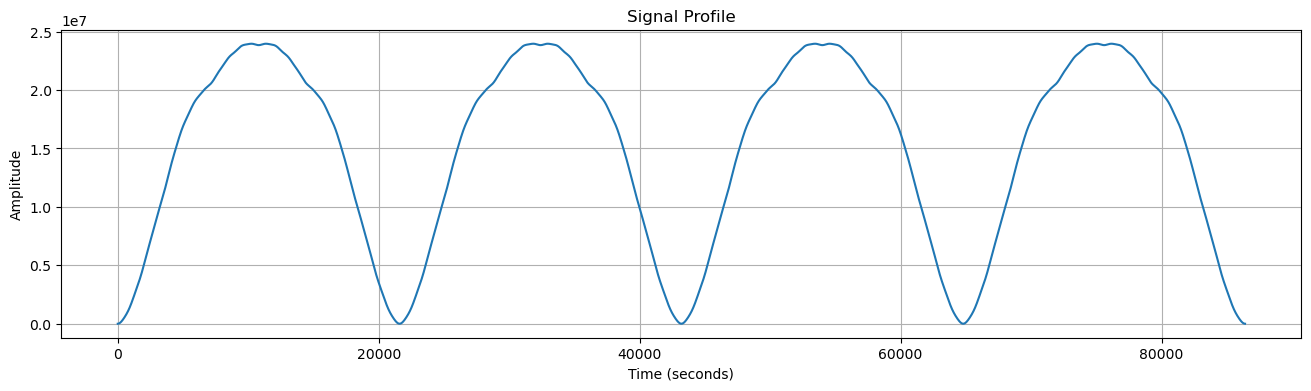

In [7]:
plotSignal(t, Xcum, 'Signal Profile')

In [8]:
start = 0  # Start in seconds.
stop = 60 * 60  # Stop in seconds.
start = int(start * (1/Fs))
stop = int(stop * (1/Fs))
W = np.array([t[start:stop] , Xcum[start:stop]])

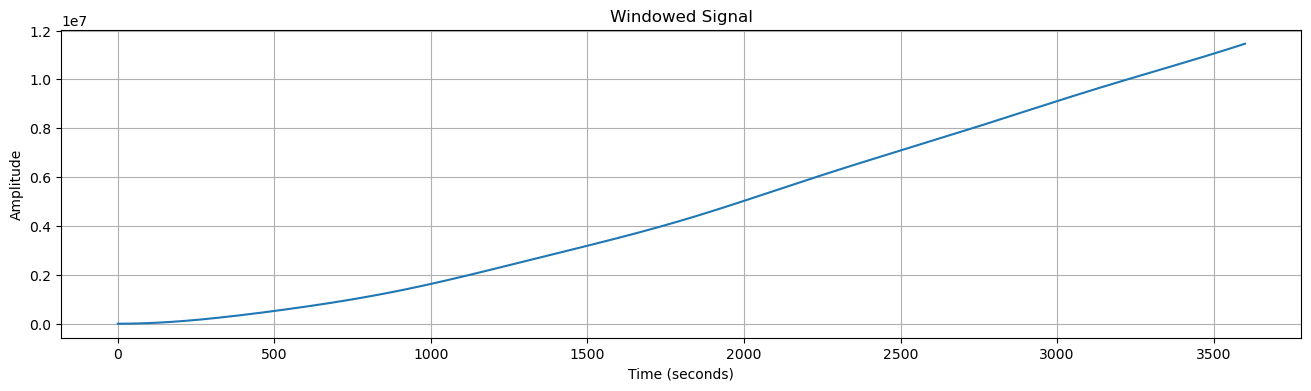

In [9]:
plotSignal(W[0], W[1], 'Windowed Signal')

In [10]:
Dstd, trend, detrend = DFA.detrendSignal(W[1])

Standard deviation from from this window - 453398.0488881424


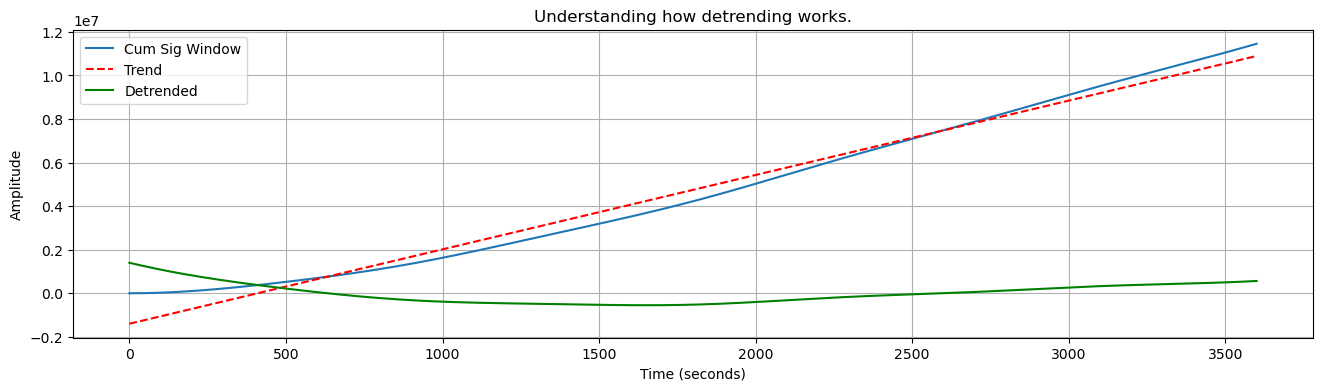

In [11]:
f = plt.figure(figsize=(16, 4))
plt.title('Understanding how detrending works.')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(W[0], W[1], label='Cum Sig Window')  
plt.plot(W[0], trend, 'r--', label='Trend')
plt.plot(W[0], detrend, 'g-', label='Detrended')
plt.legend()
plt.grid()

print('Standard deviation from from this window - {}'.format(Dstd))

We will now break the signal into a various different time series windows. We create a helper function for it. Which will take as input the number seconds we want each window to be. For this test let us use the following scales of windows 

**Recommended max window size**
According to literature, it is safe to have a window size as big as 10% of the actual data duration. In our case the data duration is 24 hours. So the maximum window we can have will be 2.4 hours, or 164 minutes.

However because we are testing this out, we can go higher that 10% so we can see what the effect of the longer 6 hour period signal is (if any).

Scales we are using --> [1 minute, 30 minutes, 60 minutes, 2 hours, 5 hours]

In [12]:
"""
Change the the logic to whatever units you are using in your actual signal (we are using seconds here)
Assuming constant sampling rate signal. Make life easy for testing. 
In the real world this might not be the case.

seconds : Size of the window in seconds.
"""
def returnScaleIndexes(seconds : int, t : np.array, Fs : float):
    windows = [] # Stores the windows indexes

    window_size = seconds * (1/Fs)  # In points / indices
    nwindows = int(t.size / window_size)
    
    for i in range(0, nwindows):
        start = i*window_size
        windows += [[int(start),int(start+window_size)]]
        
    return windows

In [13]:
mTs = lambda m : m * 60
hTs = lambda h : h * 60 * 60

In [15]:
%%time
widx = returnScaleIndexes(hTs(6), t, Fs)
print(widx)
print(DFA.calDetrendFlucuation(Xcum, widx))

[[0, 2160000], [2160000, 4320000], [4320000, 6480000], [6480000, 8640000]]
8046054.497470275
CPU times: user 302 ms, sys: 103 ms, total: 405 ms
Wall time: 329 ms


In [17]:
%%time
scales = [mTs(1), mTs(30), mTs(60), hTs(2), hTs(5)]
F = []
for s in scales:
    widx = returnScaleIndexes(s, t, Fs)
    F += [DFA.calDetrendFlucuation(Xcum, widx)]

CPU times: user 1.41 s, sys: 338 ms, total: 1.75 s
Wall time: 1.57 s


We can now go ahead and calculate $\alpha$ which power for $$F(L) = L^{\alpha}$$
Where $L$ is the length of the window in points. 

We do this by converting $F(L)$ and $L$ into $log$ scale and then ploting them. As in log scale $\alpha$ is the slope. We can fit a line using linear regression if needed to find the co-relation slope $\alpha$

$$
\alpha = \frac{\log_{10} F(L)}{\log_{10} L} \
\\log_{10} F(L) = \alpha \times \log_{10} L
$$

In [18]:
L = np.array(scales)
L = L * (1 / Fs)

Llog = np.log10(L)
Flog = np.log10(F)
coef = np.polyfit(Llog, Flog, 1)
trend = np.poly1d(coef)
T = trend(Llog)

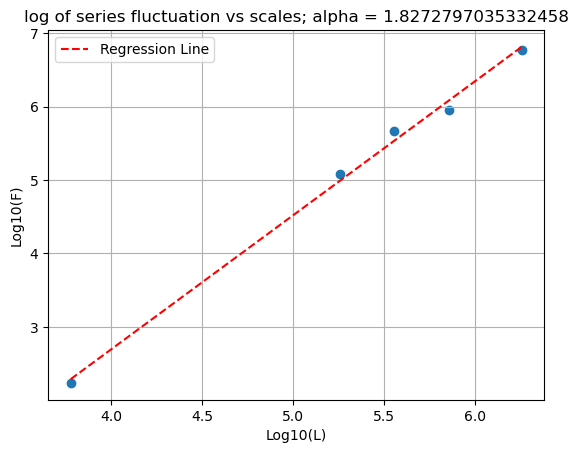

In [19]:
# Let us plot this to see if anything makes sense.
f = plt.figure()
plt.scatter(Llog, Flog)
plt.plot(Llog, T, 'r--', label='Regression Line')
plt.legend()
plt.title('log of series fluctuation vs scales; alpha = {}'.format(coef[0]))
plt.xlabel('Log10(L)')
plt.ylabel('Log10(F)')
plt.grid()

In the above example because $\alpha$ is larger than 1, this process is non-stationary. That is the value of $X(t)$ is dependent of time $t$. Or the joint probability of $X(t_{1}+\tau)$ and $X(t_{1}+\tau)$ are dependent of $\tau$. This makes sense, since the value of $\sin$ is directly dependent on the time variable $t$.

In this case the system can be modeled as a fractional Brownian process (the value $x_{t+1}$ depends on the previous value of $x_{t}$. In the case of non-stationary system the *Hurst* parameter can be calculated by $H=\alpha-1$.

In this case $H=0.82$

This can be expressed as power law with *Hurst* parameter as the power with varying scales $L$ as follows - 

$$ \sigma(Y(Lt)) = L^{H} \times \sigma(Y(t)) $$

Where 

$Y(Lt)$ : Value of the signal $Y$ with a time window of $L\times t$ \
$Y(t)$ : Value of the signal $Y$ with a time window of $t$ \
$L$ : Is the multiplier to scale the window \
$H$ : Hurst parameter \
$\sigma$ : Standard deviation

Using this to show an example in our system with $H=0.82$

$$ \sigma(Y(Lt=60\times5)) = L^{0.82} \times \sigma(Y(t=60)) $$

It means for a signal in our system, the standard deviation of the signal at 5 mins ($Lt$) will obey the above power law relation to the standard deviation of the signal from the same system with a scale of 1 min ($t$)

# Interpreting various values of Alpha

* 0 < α < 0.5 then the process has a memory, and it exhibits anti-correlations. (can be modeled by a fGn with H = α)
* 0.5 < α < 1 then the process has a memory, and it exhibits positive correlations. (can be modeled by a fGn with H = α)
* α = 0.5 then the process is indistinguishable from a random process with no memory. (can be modeled by a fGn with H = α). See the example of how $\alpha$ was derived to 0.5 using the random walk method.
* 1 < α < 2 then the process is non-stationary. (can be modeled as a fBm with H = α − 1).